# 0.0 IMPORTS


## 0.1 Libraries

In [241]:
import pandas               as pd
import numpy                as np
import seaborn              as sns
import matplotlib.pyplot    as plt
import matplotlib.gridspec  as gridspec
import xgboost              as xgb
import inflection 
import math
import datetime
import warnings
import random
import pickle
import requests
from IPython.core.display           import HTML
from IPython.display                import Image
from tabulate                       import tabulate
from scipy                          import stats
from sklearn.preprocessing          import RobustScaler, MinMaxScaler, LabelEncoder
from boruta                         import BorutaPy
from sklearn.ensemble               import RandomForestRegressor
from sklearn.metrics                import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model           import LinearRegression, Lasso


## 0.2 Helper Functions

In [180]:
def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r,k = cm.shape
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0 ,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def mean_absolute_percentage_error(y, yhat):
      return np.mean(np.abs((y - yhat) / y))  

def mean_percentage_error(y, yhat):
      return np.mean((y - yhat) / y)

def ml_error (model_name, y, yhat):
    mae = mean_absolute_error (y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):


    mae_list = []
    mape_list = []
    rmse_list = []


    for k in reversed( range(1, kfold+1) ):
        if verbose:
            print ('\nKFold Number: {}'.format(k))

        # Start and end date for validation (Primeiras 6 semanas)

        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset

        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset

        ## training 
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        ##validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model

        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, index=[0])


## 0.3 Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')


# 1.0 PASSO 01 - DESCRICAO DOS DADOS


In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns


In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore (x) 
cols_new = list(map (snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2 Data Dimensions


In [7]:
print('Number of rows: {}'.format (df1.shape[0]))
print('Number of rows: {}'.format (df1.shape[1]))

Number of rows: 1017209
Number of rows: 18


## 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

# Mostrar colunas que tem valores NA

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA


In [10]:
df1['competition_distance'].max()

75860.0

In [11]:
# competition_distance              2642

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan( x ) else x)

# competition_open_since_month    323348
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year     323348
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week               508031
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year               508031
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval                  508031
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dez'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistics

In [14]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])


### 1.7.1 Numerical Attributes

In [15]:
# Central Tendency - mean, median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()

m.columns = ['attibutes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kutosis']

In [16]:
m

,attibutes,min,max,range,mean,median,std,skew,kutosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

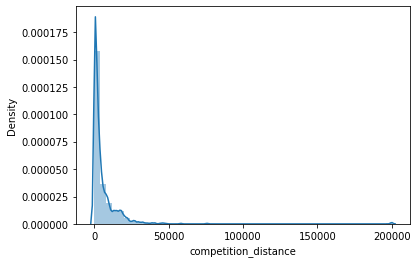

In [17]:
sns.distplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [18]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

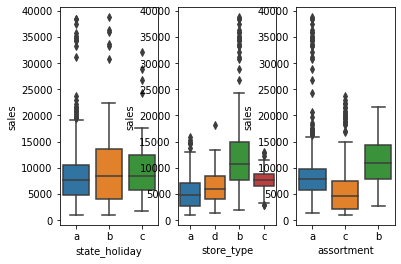

In [19]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)


# 2.0 PASSO 02 - FEATURE ENGINEERING

In [20]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

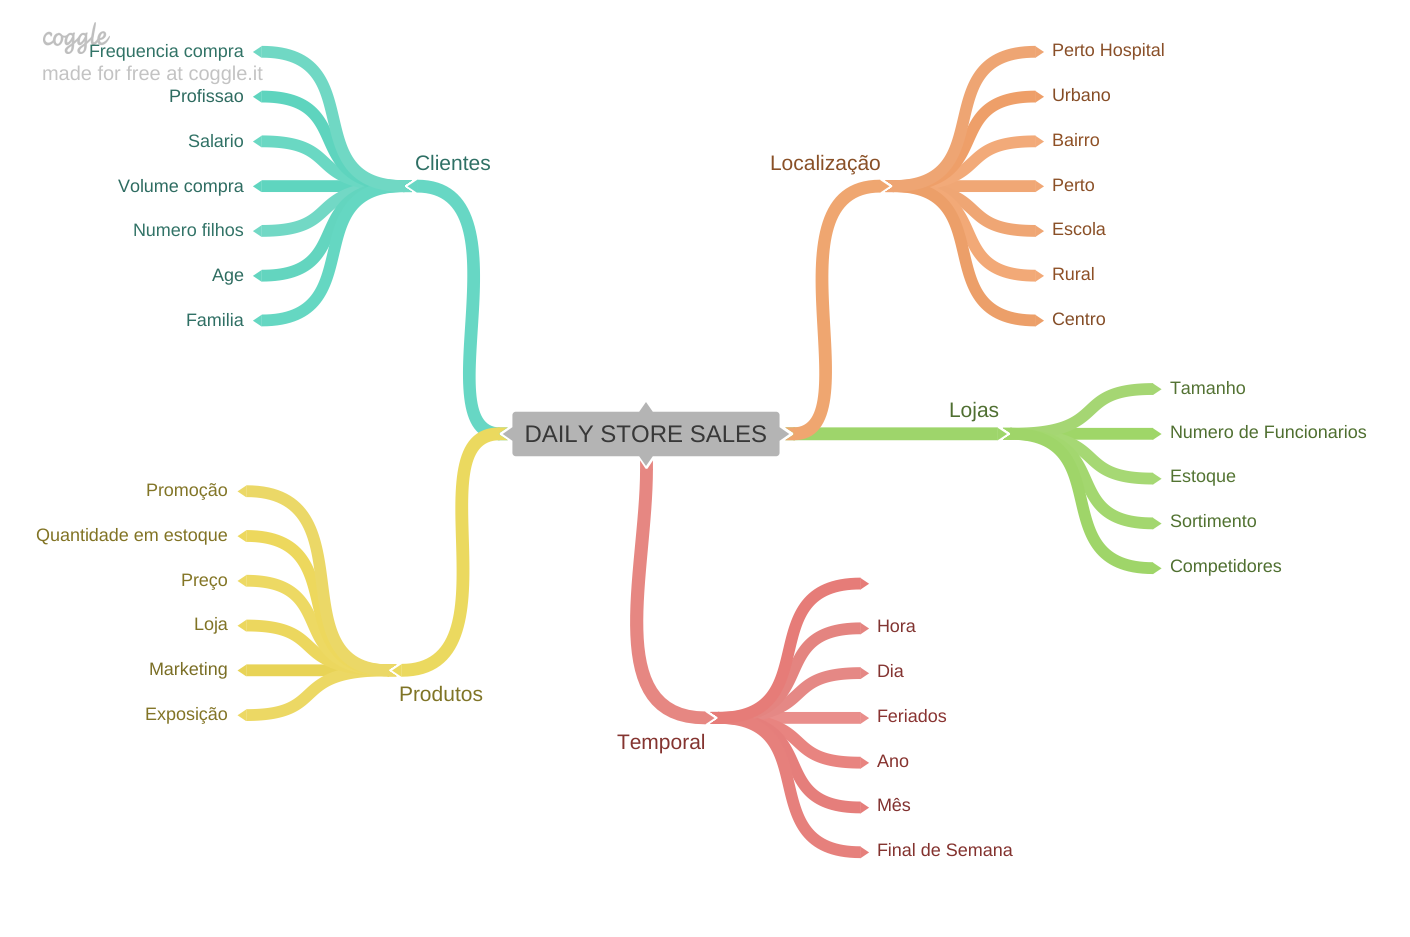

In [21]:
Image ('img/DAILY_STORE_SALES.png')

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais proximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expoem mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem precos menores nos produtos deveriam vender mais.

**4.** Lojas que tem promocoes mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promocao deveriam vender mais.

**7.** Lojas que tem mais promocoes consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas que abrem no feriado do Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos nos feriados escolares.

## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais proximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promocao deveriam vender mais.

**6.** Lojas que tem mais promocoes consecutivas deveriam vender mais.

**7.** Lojas que abrem no feriado do Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos nos feriados escolares.

## 2.4 Feature Engineering

In [22]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime (x + '-1', '%Y-%W-%w') - datetime.timedelta (days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


In [23]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 PASSO 03 - FILTRAGEM DAS VARIÁVEIS

In [24]:
df3 = df2.copy()

In [25]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

In [26]:
df3 = df3[(df3['open'] != 0) &  (df3['sales'] > 0)]

## 3.2 Seleção das colunas

In [27]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)


In [28]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [29]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

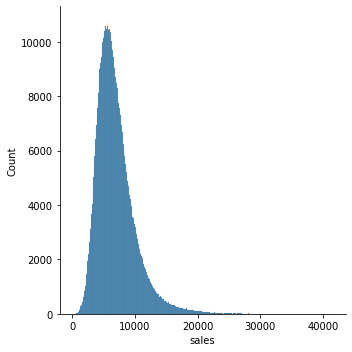

In [30]:
sns.displot(df4['sales'])

### 4.1.2 Numerical Variable

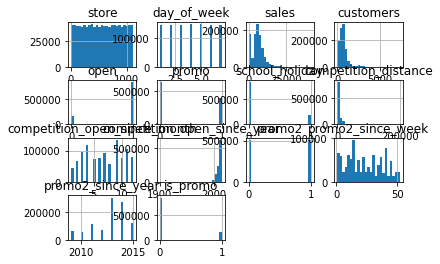

In [31]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

In [32]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [33]:
# State Holiday

df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


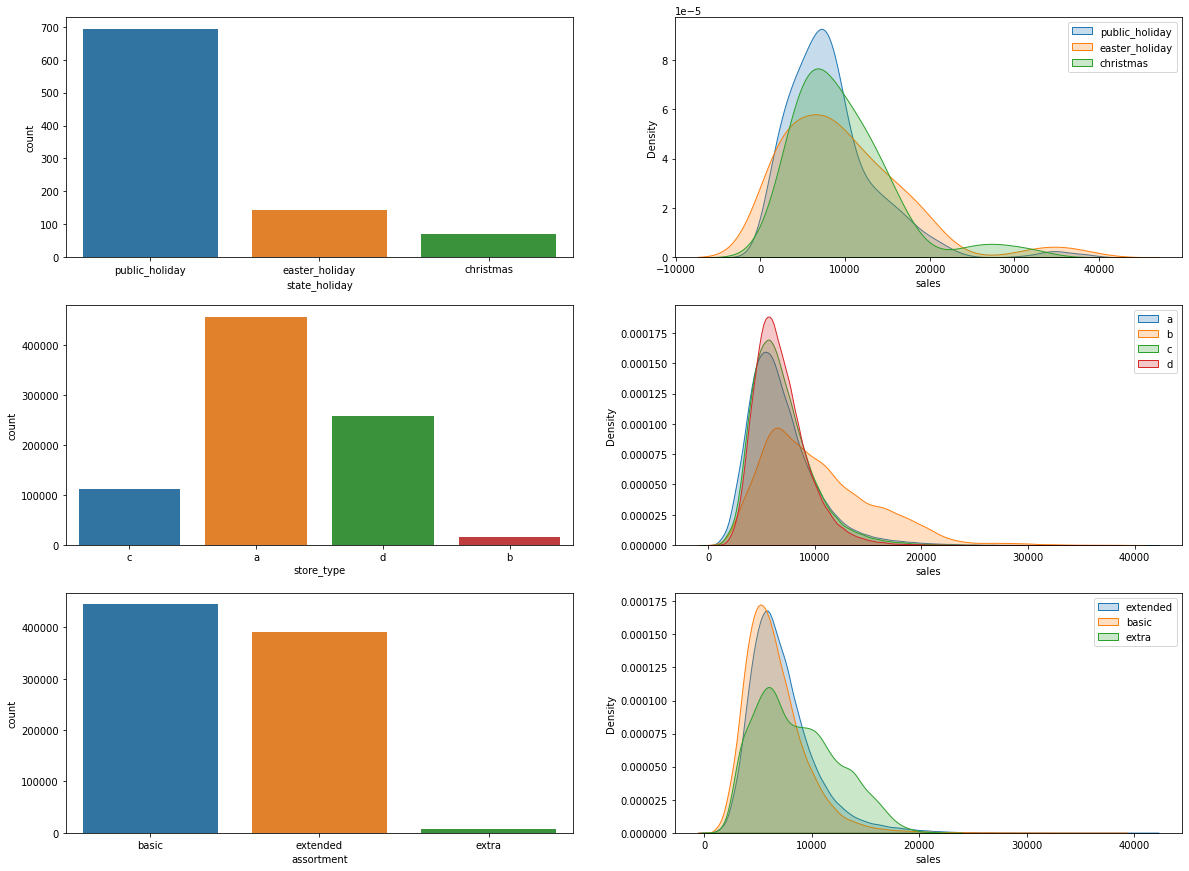

In [34]:

plt.figure(figsize=(20, 15))

# State Holiday

plt.subplot(3,2,1)

a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
plt.legend()

# Store type
plt.subplot(3,2,3)

sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)
plt.legend()

# Assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)
plt.legend()




## 4.2 Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais.


**FALSA** Lojas com maior sortimento vendem menos


<AxesSubplot:xlabel='year_week'>

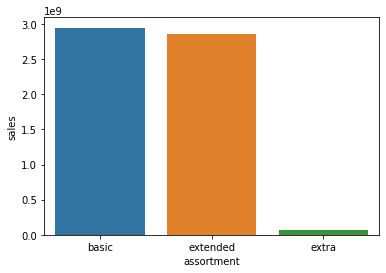

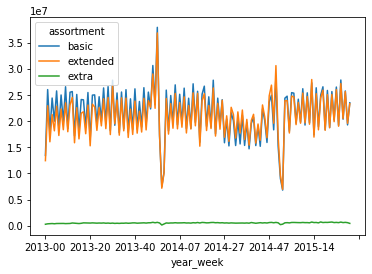

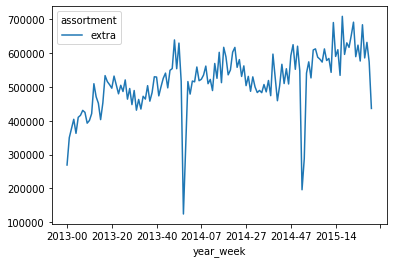

In [35]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()


In [36]:
aux3.head()

,year_week,assortment,sales
2,2013-00,extra,269404
5,2013-01,extra,350279
8,2013-02,extra,377207
11,2013-03,extra,404662
14,2013-04,extra,363061


### H2. Lojas com competidores mais proximos deveriam vender menos.


**FALSA** Lojas com competidores mais proximos vendem MAIS

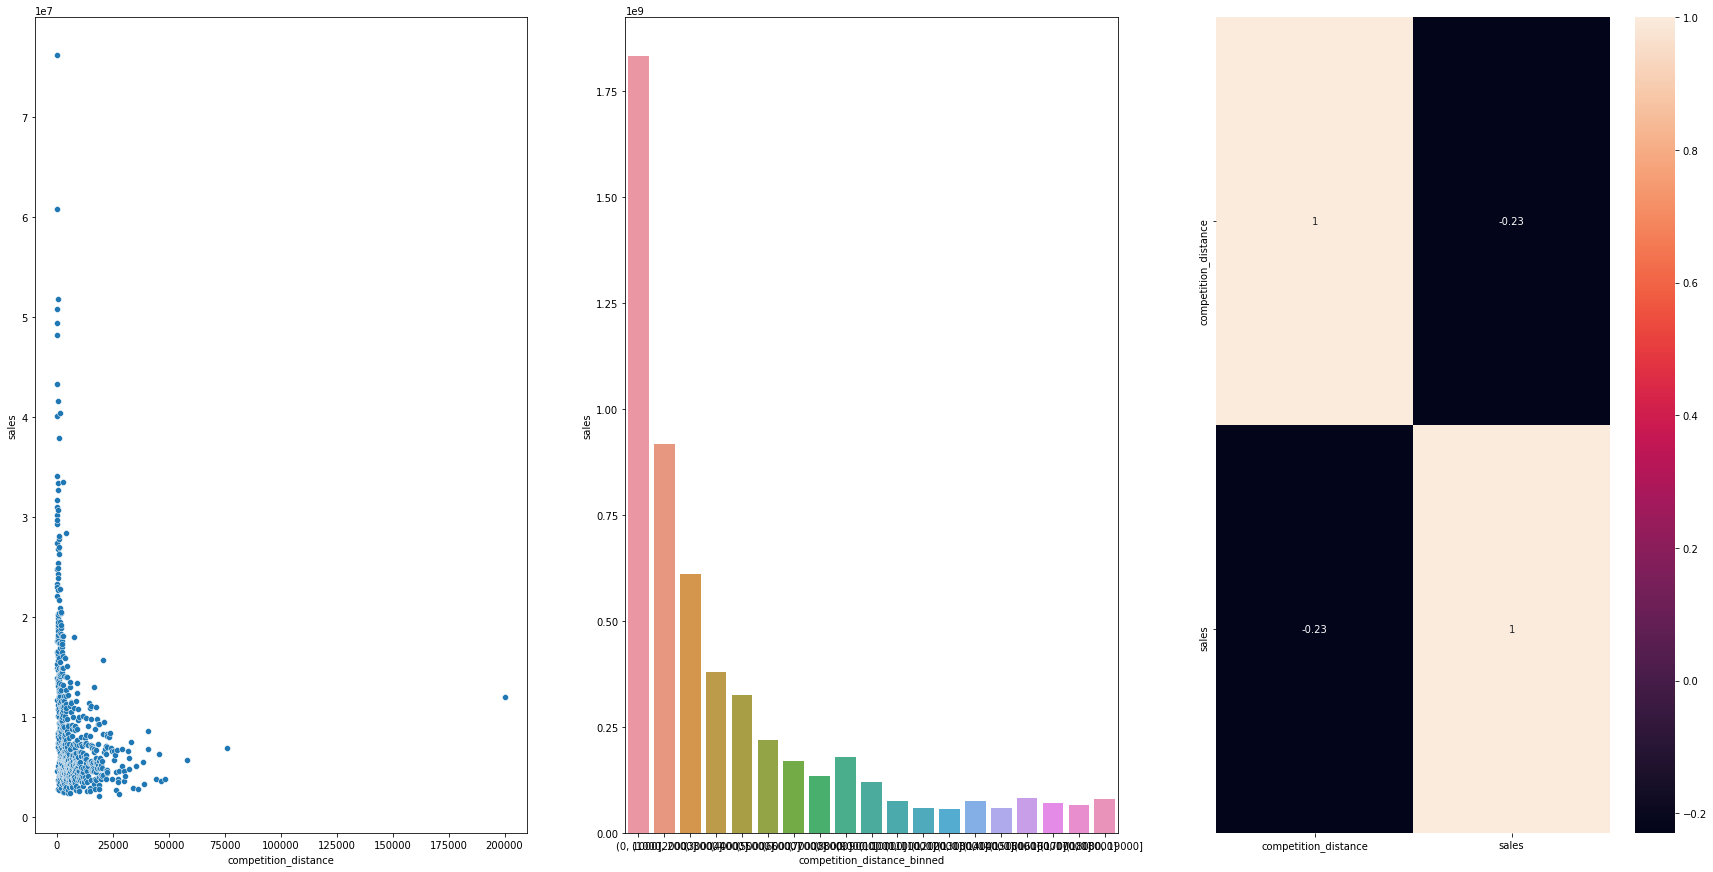

In [37]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(30, 15))

plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1);

bins = list (np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(1,3,2)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3. Lojas com competidores a mais tempo deveriam vender mais.

**FALSA** Lojas com competidores a mais tempo vendem MENOS

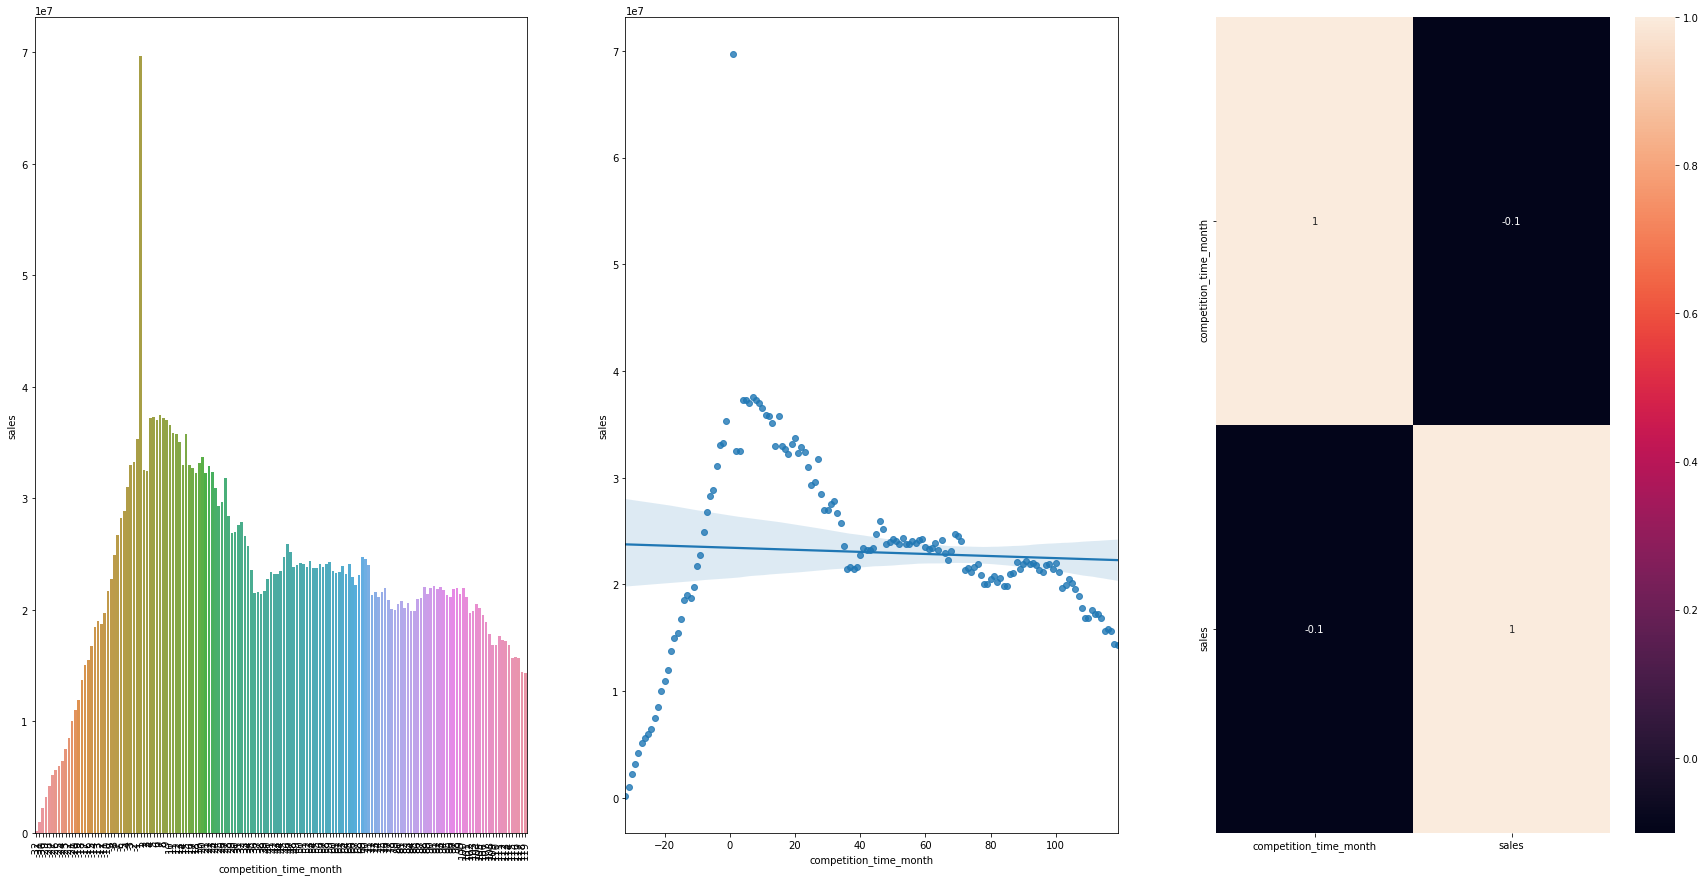

In [38]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] <120) & (aux1['competition_time_month'] != 0)]

plt.figure(figsize=(30, 15))

plt.subplot(1,3,1)
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H4. Lojas com promocoes ativas por mais tempo deveriam vender mais.

**FALSA** Lojas com promocoes ativas por mais tempo vendem regularmente mais depois de um certo tempo elas decaem.

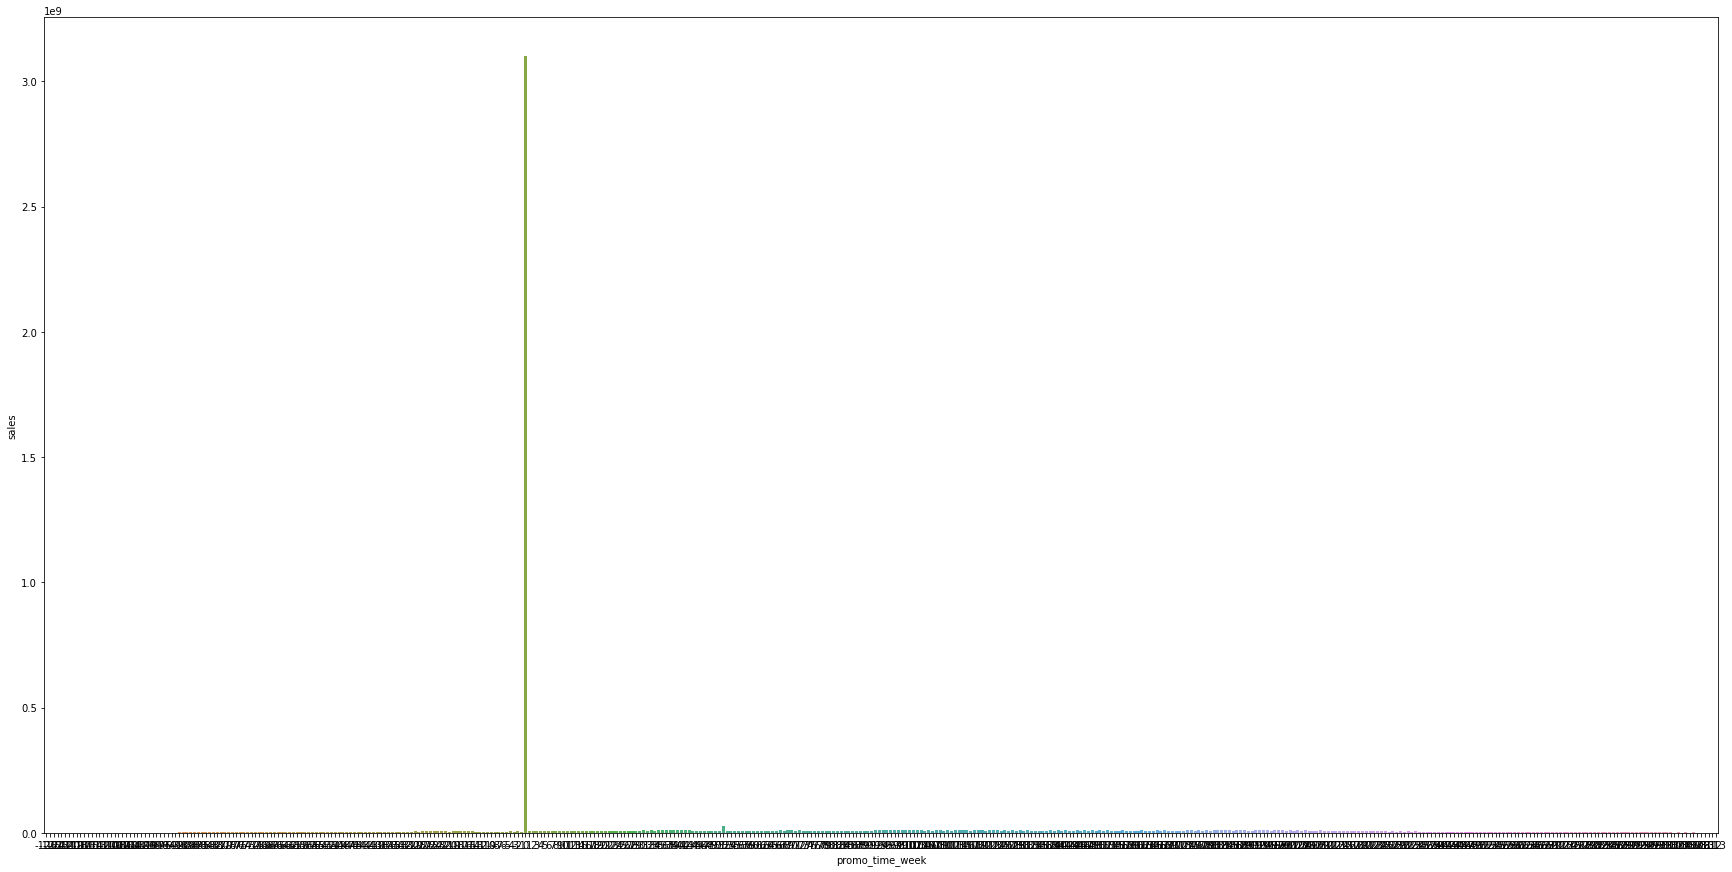

In [39]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index() 


plt.figure(figsize=(30, 15))
sns.barplot(x='promo_time_week', y='sales', data=aux1);  
    

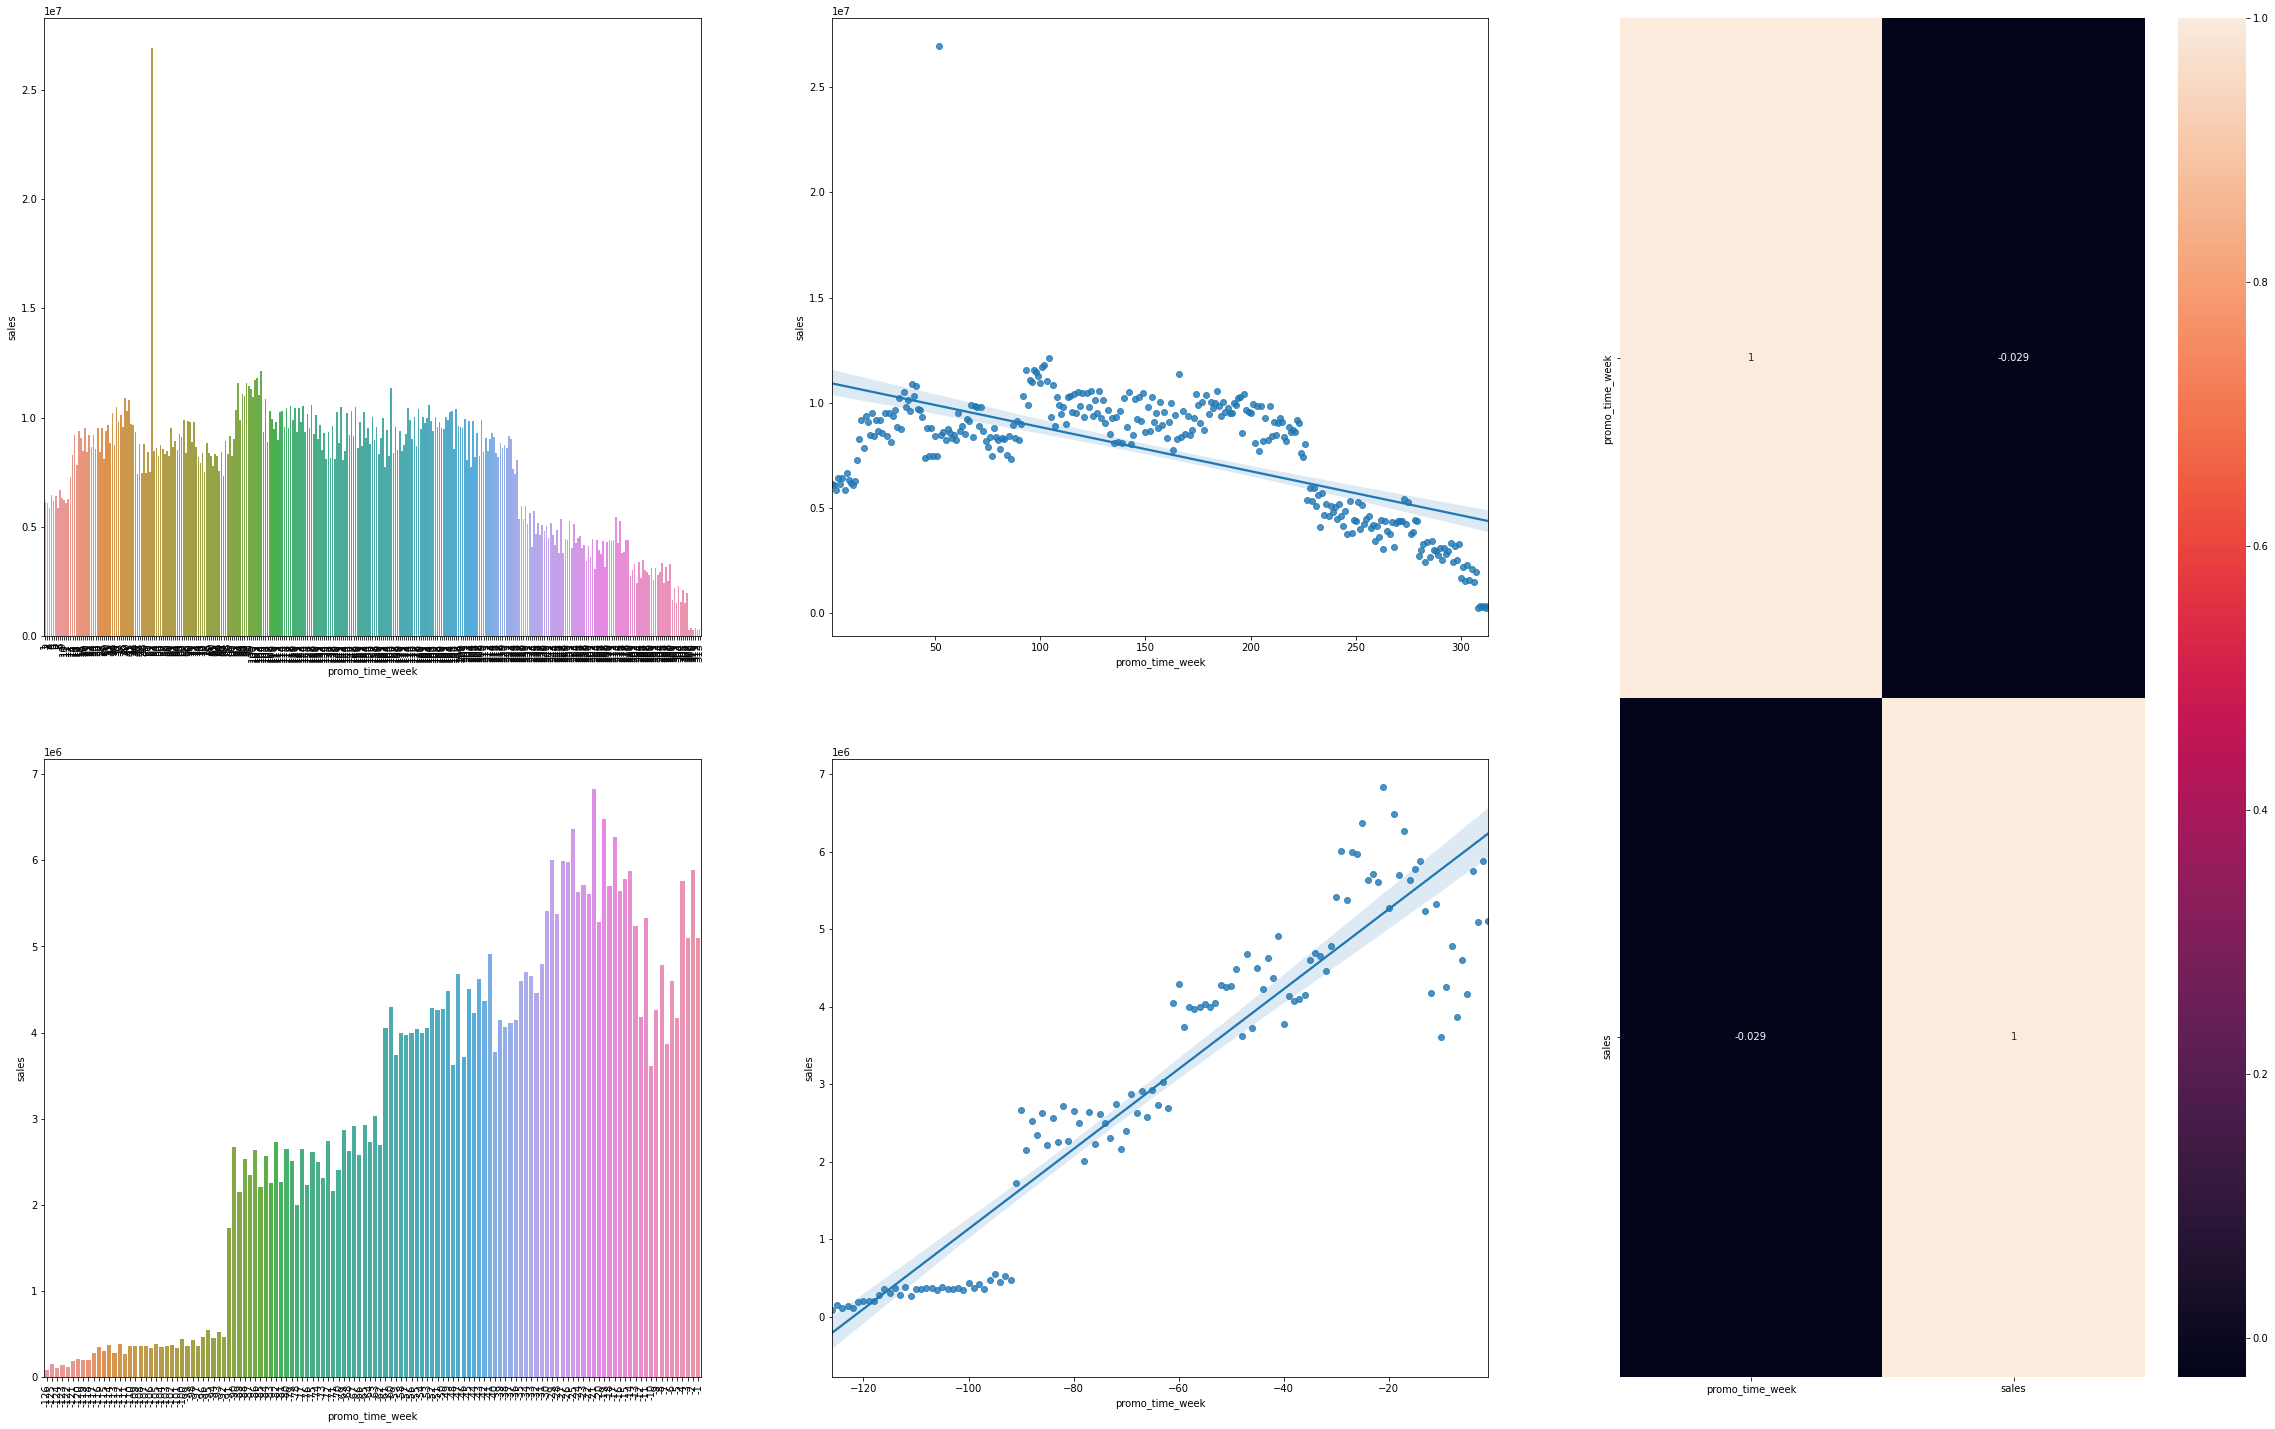

In [40]:
plt.figure(figsize=(40, 25))

grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0]) 
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido 
sns.barplot(x='promo_time_week', y='sales', data=aux2); 
plt.xticks(rotation=90);  

plt.subplot(grid[0,1]) 
sns.regplot(x='promo_time_week', y='sales', data=aux2); 

plt.subplot(grid[1,0]) 
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular 
sns.barplot(x='promo_time_week', y='sales', data=aux3); 
plt.xticks(rotation=90);
    
plt.subplot(grid[1,1]) 
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s> H5. Lojas com mais dias de promocao deveriam vender mais. <s>



### H6. Lojas que tem mais promocoes consecutivas deveriam vender mais.

**FALSA** Lojas com mais promocoes consecutivas vendem MENOS.

In [41]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()


,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


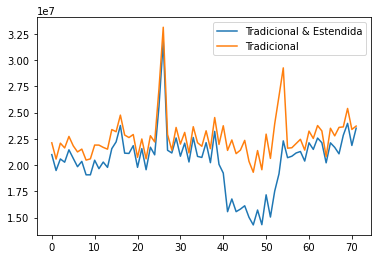

In [42]:
# 1
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Estendida', 'Tradicional'])

### H7. Lojas que abrem no feriado do Natal deveriam vender mais.

**FALSA**  Lojas que abrem no feriado do Natal vendem MENOS.

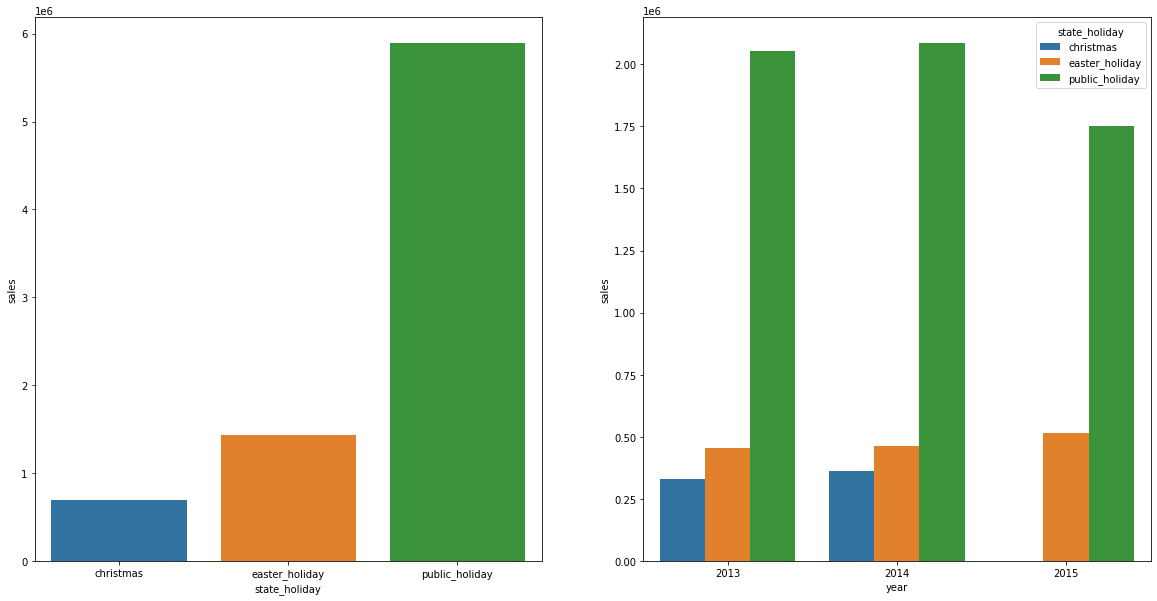

In [43]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);


### H8. Lojas deveriam vender mais ao longo dos anos.

**FALSA** Lojas vendem MENOS ao longo dos anos.

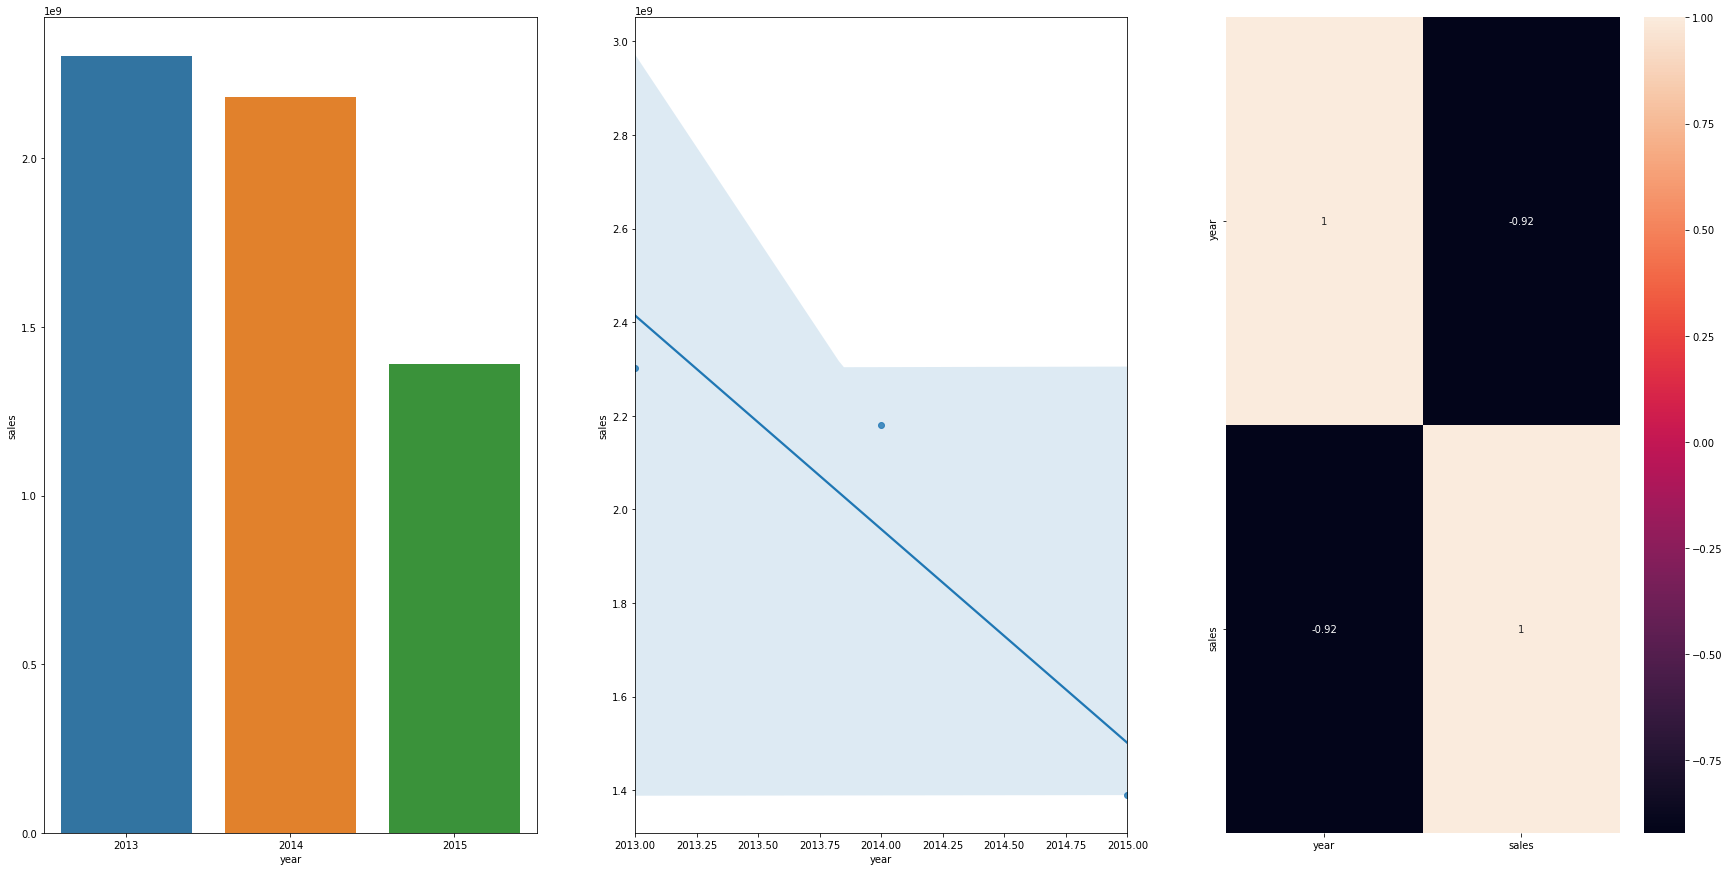

In [44]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()


plt.figure(figsize=(30, 15))

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H9. Lojas deveriam vender mais no segundo semestre do ano.

**FALSA** Lojas vendem MENOS no segundo semestre do ano.

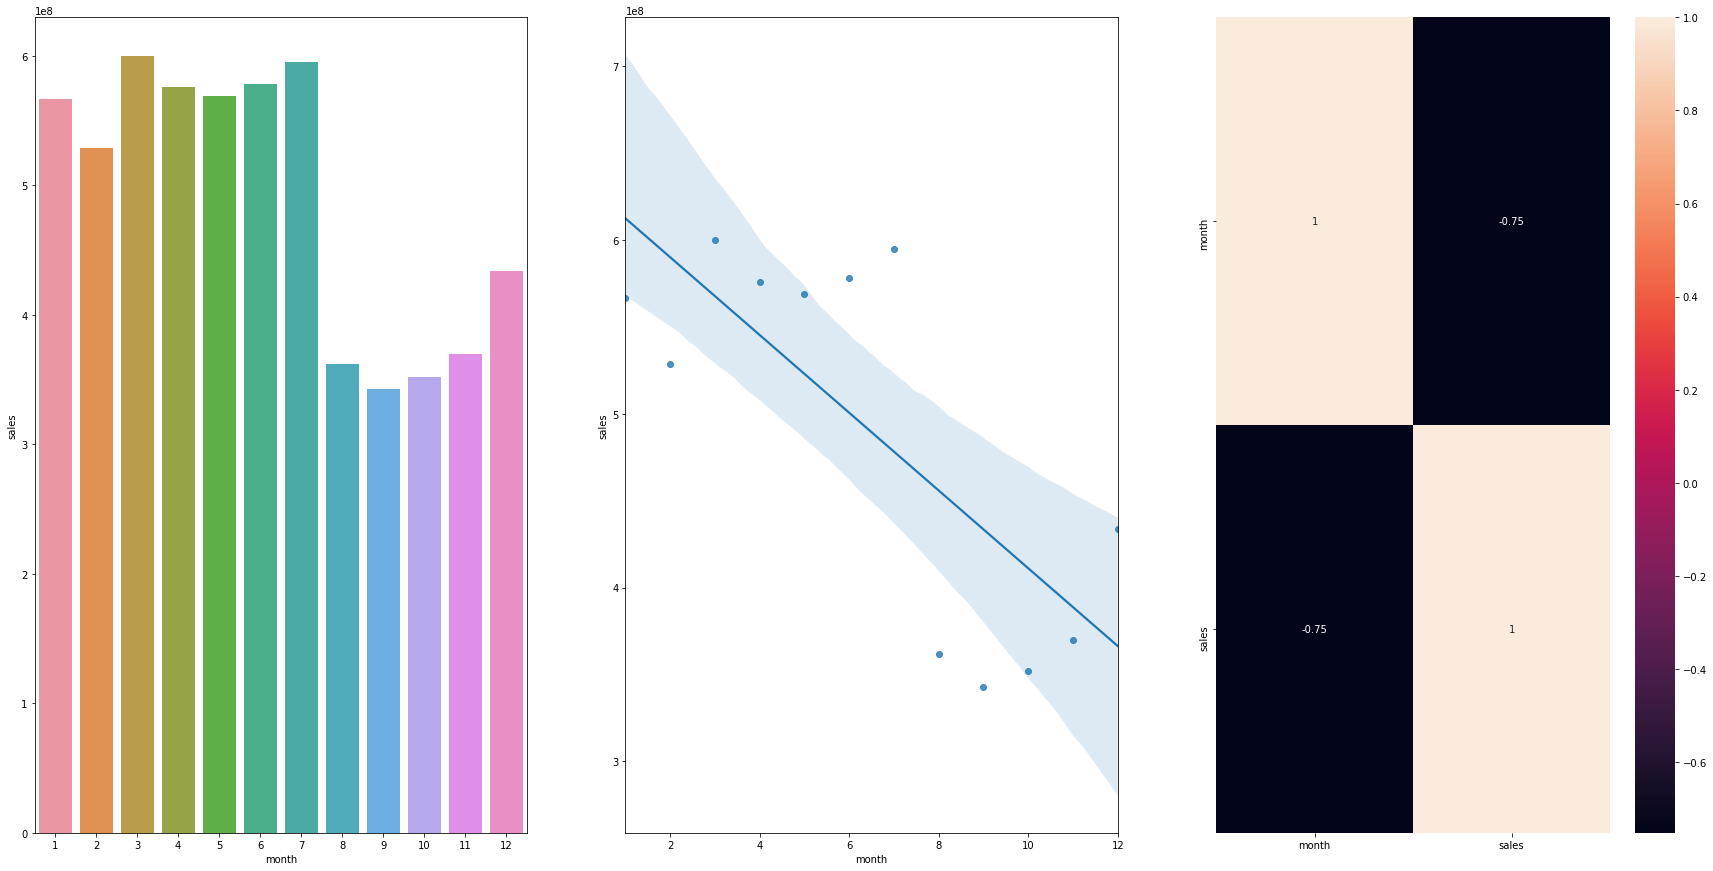

In [45]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()


plt.figure(figsize=(30, 15))

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.

**VERDADEIRA** Lojas vendem MAIS depois do dia 10 de cada mês.

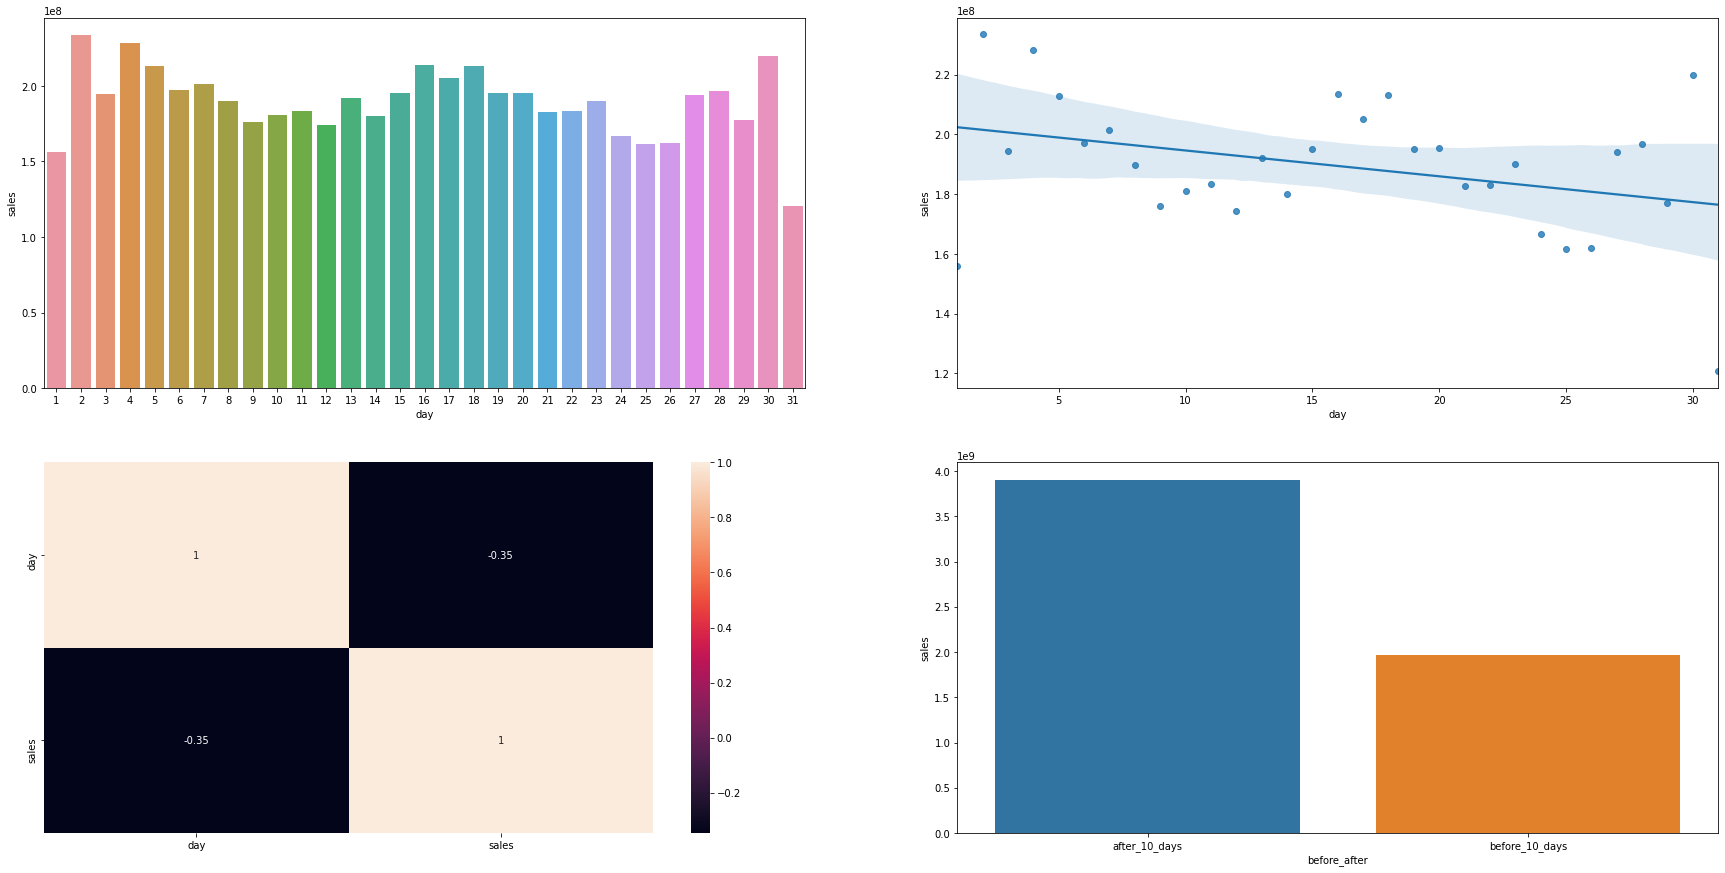

In [46]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(30, 15))

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2);



### H11. Lojas deveriam vender menos aos finais de semana.

**VERDADEIRA** Lojas vendem menos aos finais de semana.

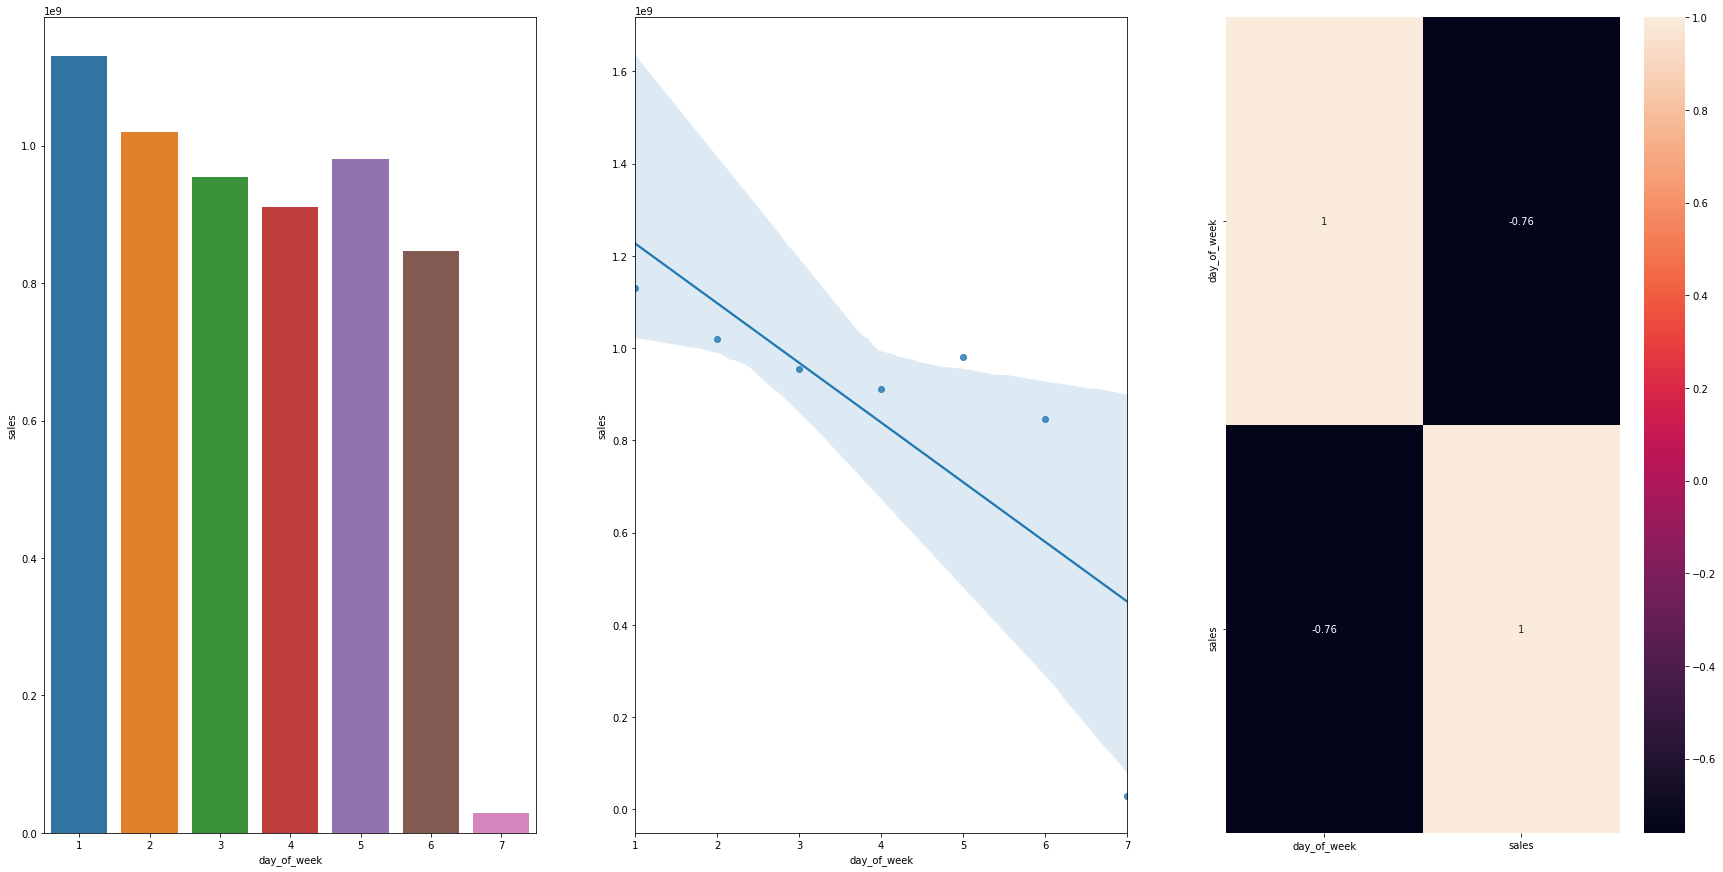

In [47]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(30, 15))

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12. Lojas deveriam vender menos nos feriados escolares.

**VERDADEIRO** Lojas vendem menos nos feriados escolares, exceto nos meses de Julho e Agosto.

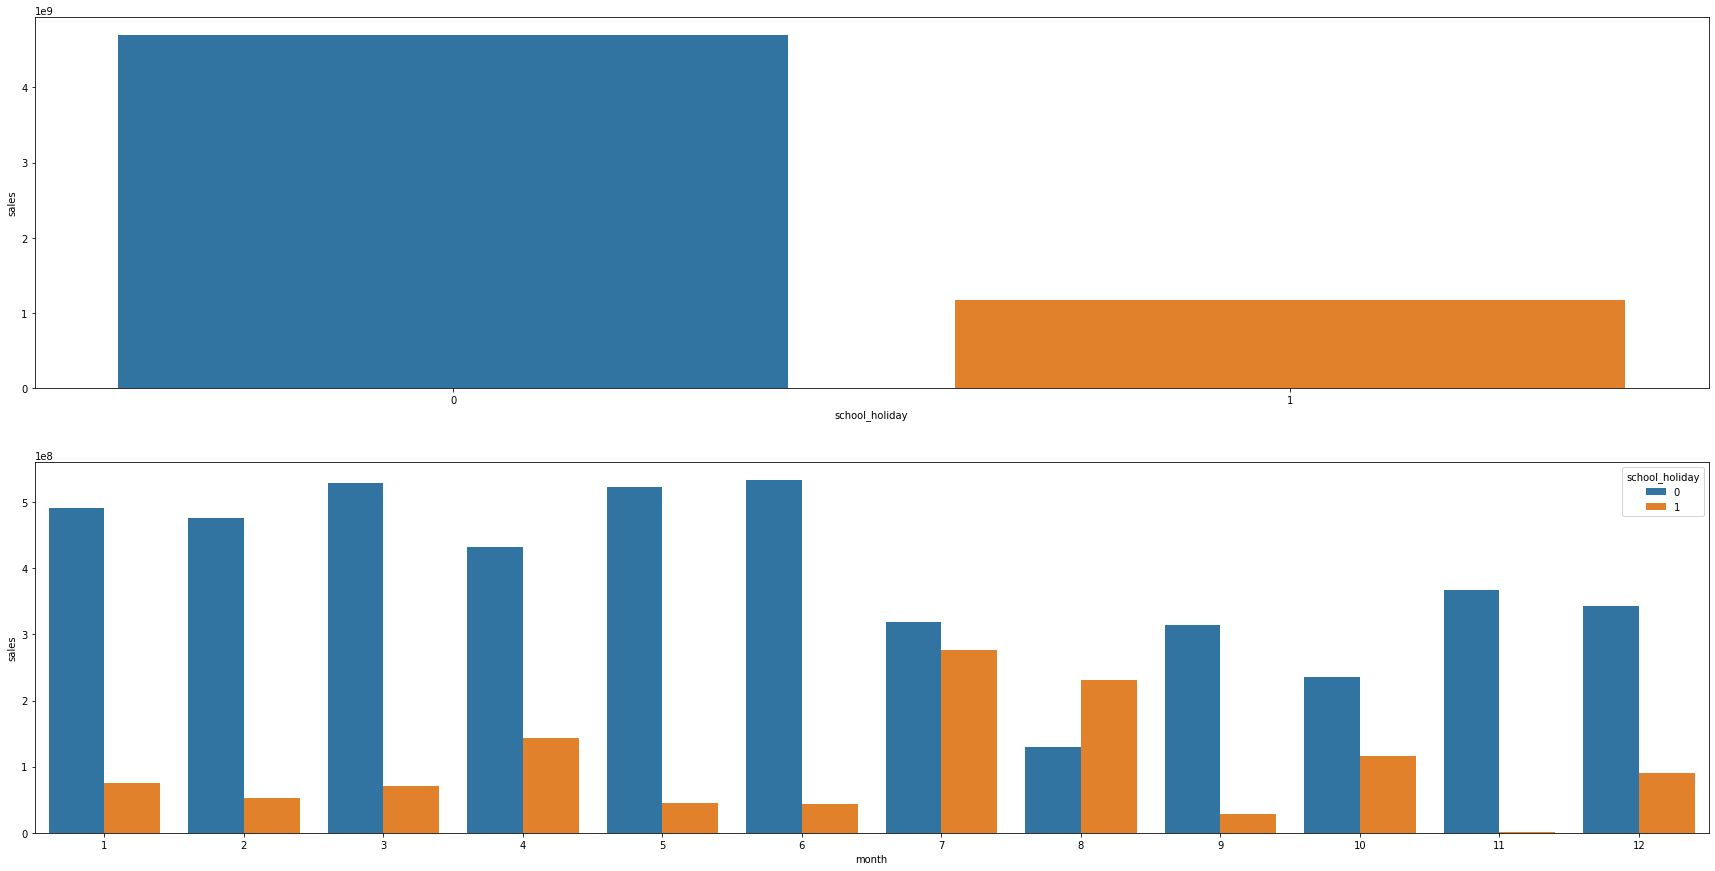

In [48]:
plt.figure(figsize=(30, 15))
plt.subplot (2,1,1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot (2,1,2)
aux2 = df4[['month' ,'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1 Resumo das Hipóteses


In [49]:
tab = [['Hipóteses', 'Conclusão', 'Relevância'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Média'],
      ['H3', 'Falsa', 'Média'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Média'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa'],
      ]

print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Média
H3           Falsa        Média
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Média
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

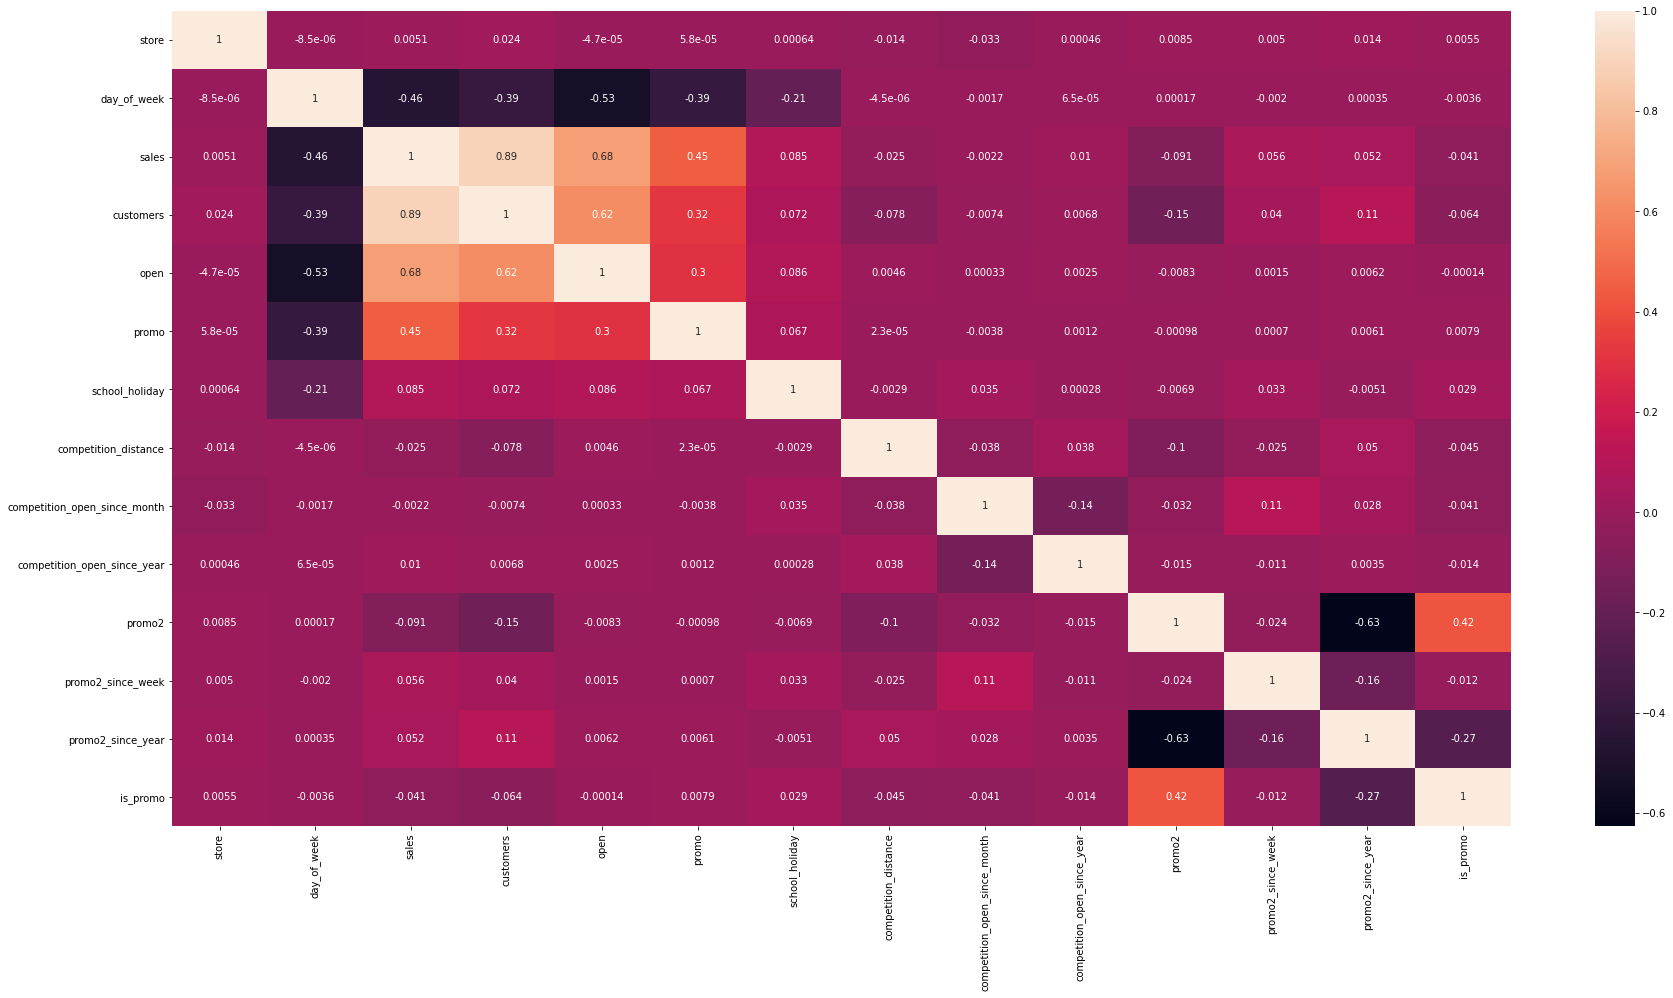

In [50]:
correlation = num_attributes.corr(method='pearson')

plt.figure(figsize=(30, 15))
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorial Attributes

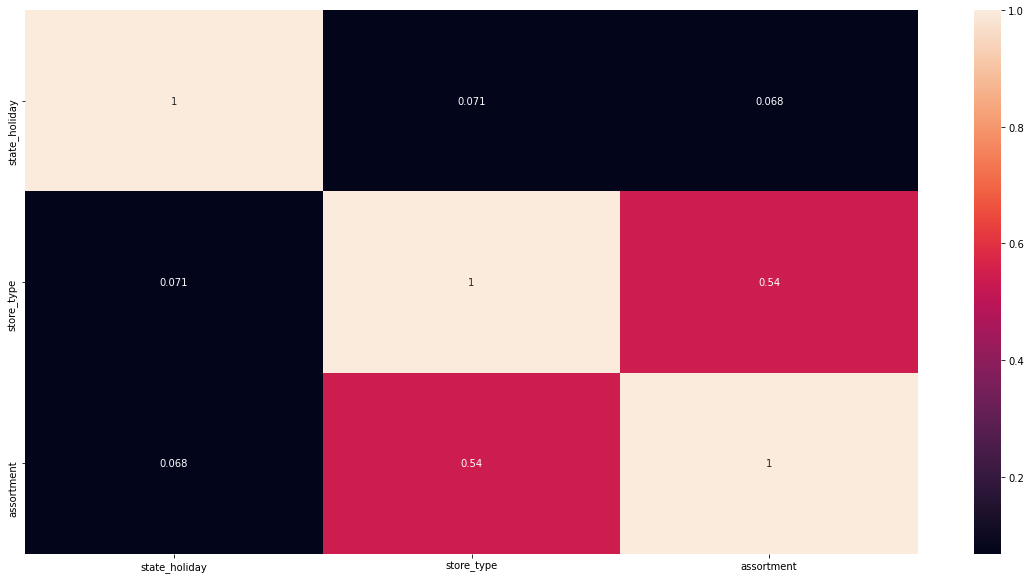

In [51]:
# Only categorical data
a = df4.select_dtypes(include='object')

# Calculate Cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame({'state_holiday': [a1,a2,a3], 
             'store_type': [a4,a5,a6],
             'assortment': [a7,a8,a9]})

d = d.set_index(d.columns)

plt.figure(figsize=(20, 10))
sns.heatmap(d, annot=True);

# 5.0 PASSO 05 - PREPARAÇÃO DOS DADOS

In [222]:
 df5 = df4.copy()

## 5.1 Normalização

## 5.2 Rescaling

In [53]:
# Min-Max Scaler :
# Robust Scaler :para dados com outliers muito forte

In [54]:
a = df5.select_dtypes(include=['int64', 'float64'])

In [55]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,4,0


/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='competition_distance'>

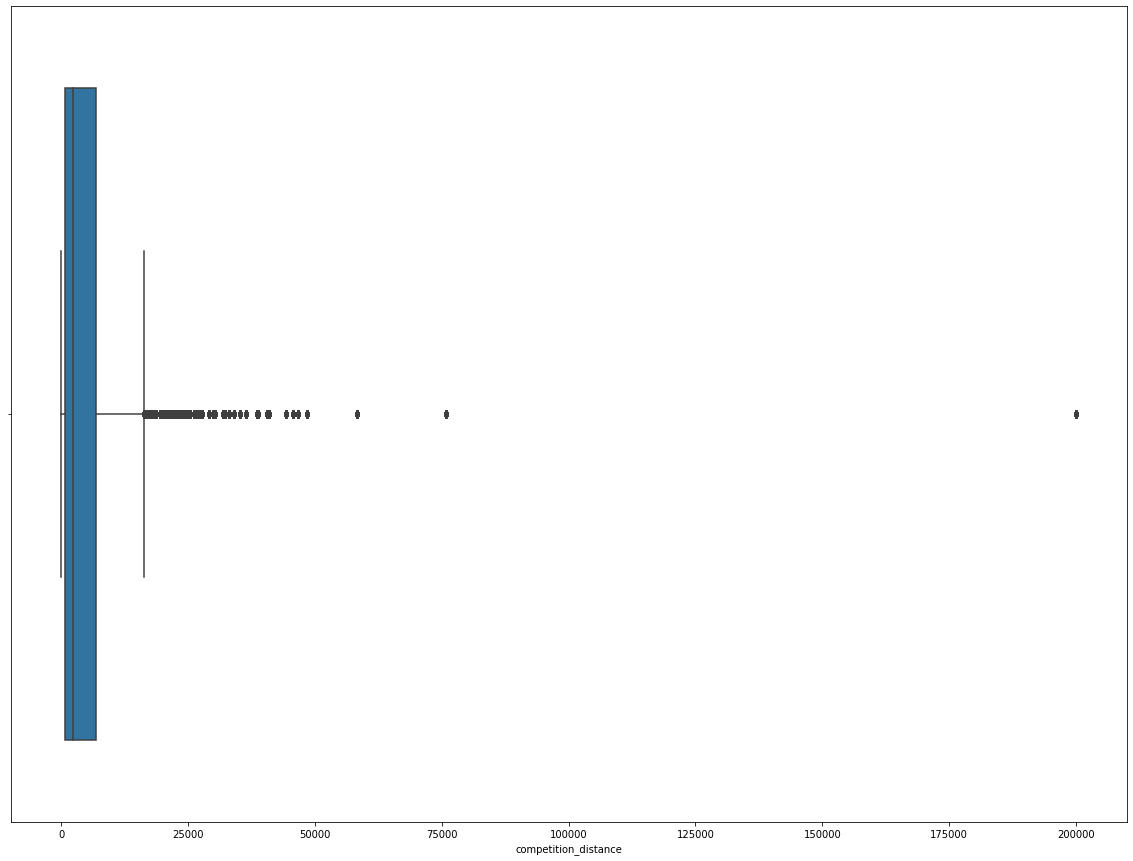

In [56]:
plt.figure(figsize=(20,15))
sns.boxplot(df5['competition_distance'])

/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='competition_time_month'>

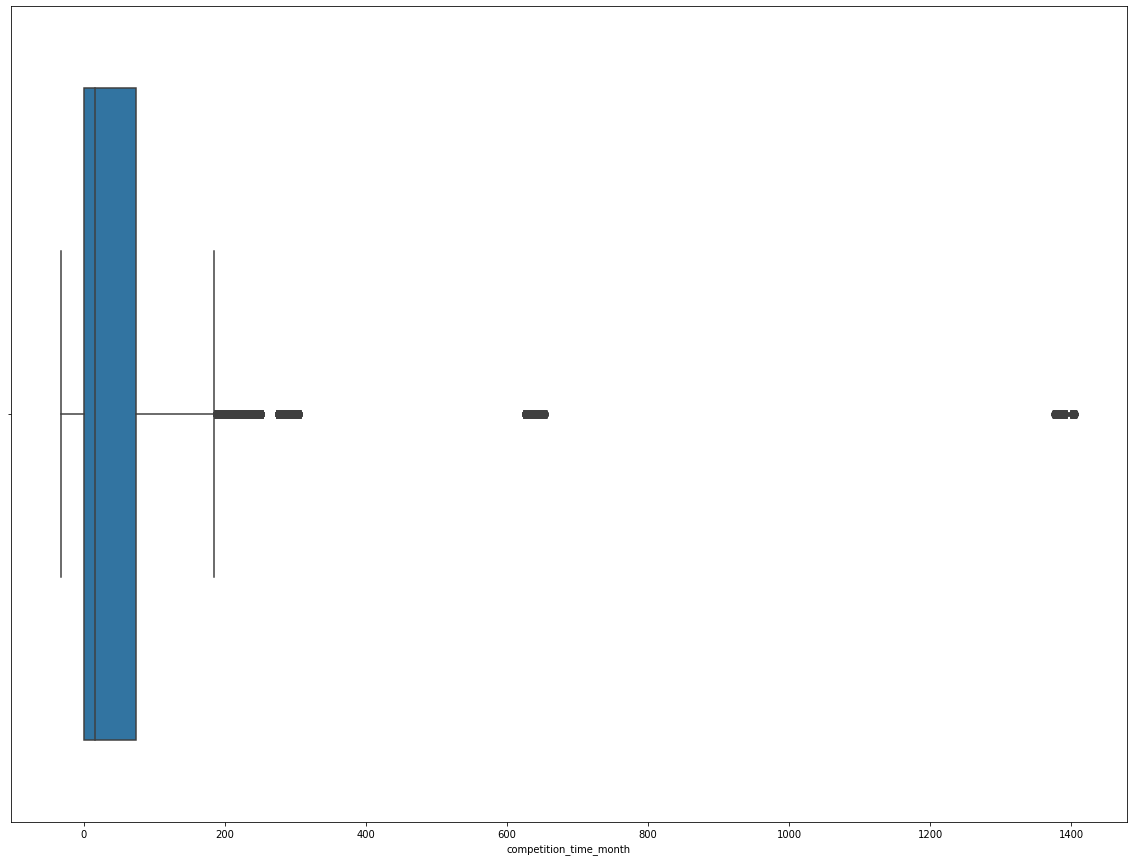

In [57]:
plt.figure(figsize=(20,15))
sns.boxplot(df5['competition_time_month'])

/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='promo_time_week'>

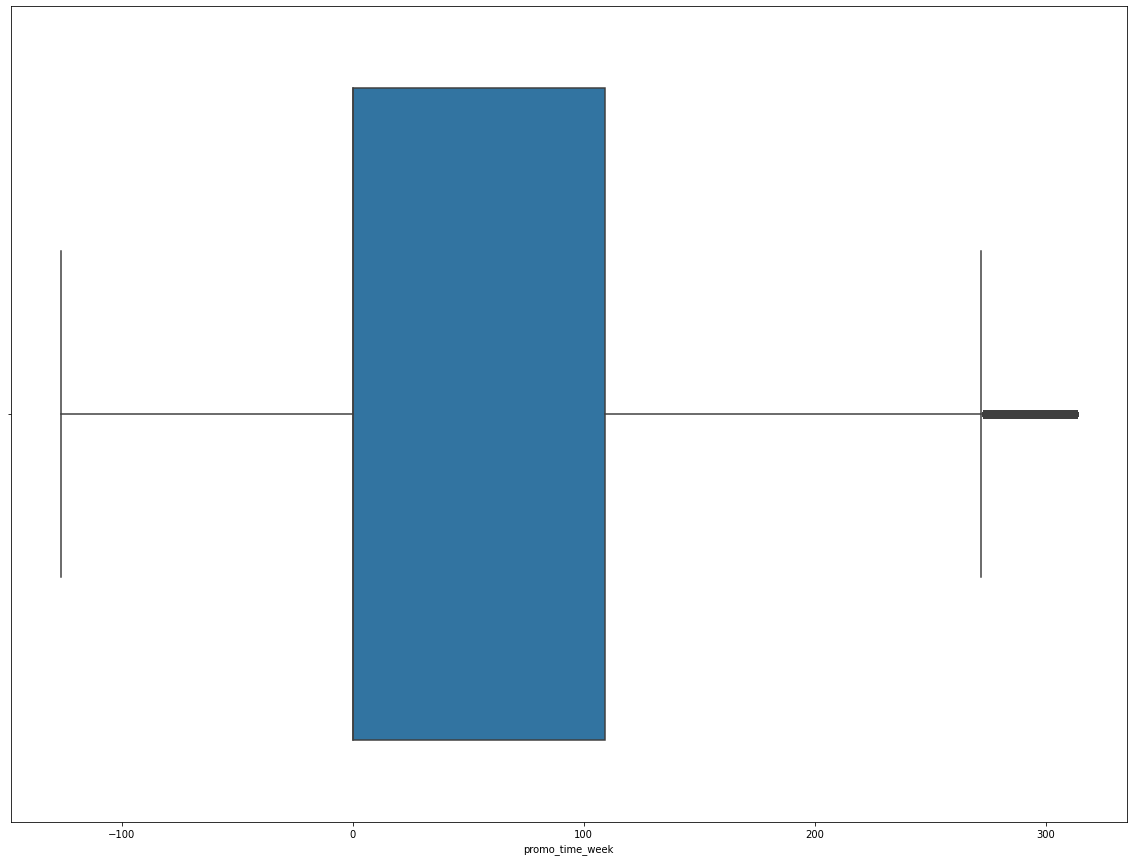

In [58]:
plt.figure(figsize=(20,15))
sns.boxplot(df5['promo_time_week'])

/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year'>

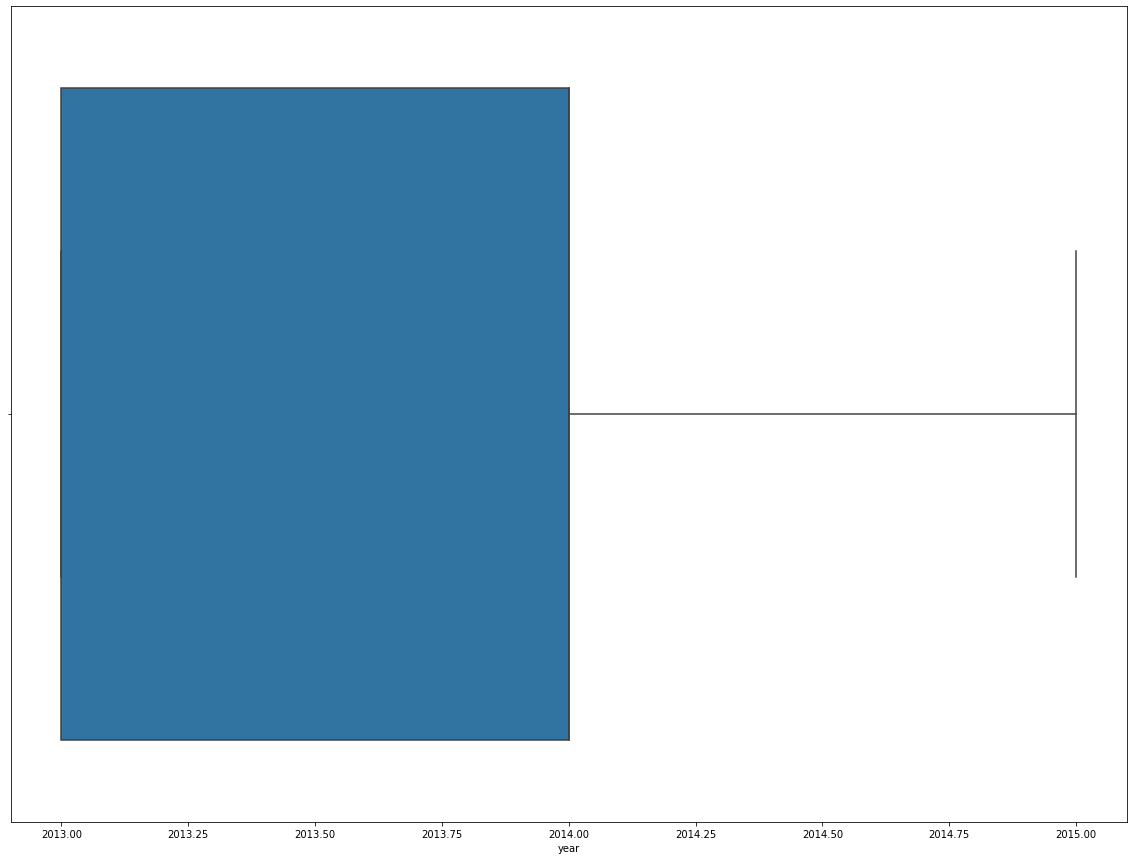

In [59]:
plt.figure(figsize=(20,15))
sns.boxplot(df5['year'])

In [228]:

rs = RobustScaler()
mms = MinMaxScaler()
# competitiion distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values )
pickle.dump( rs, open('parameter/competition_distance_scaler.pkl', 'wb'))


# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )
pickle.dump( rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week (Min-Max Scaler)
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values )
pickle.dump( rs, open('parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values )
pickle.dump( mms, open('parameter/year_scaler.pkl', 'wb'))



/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


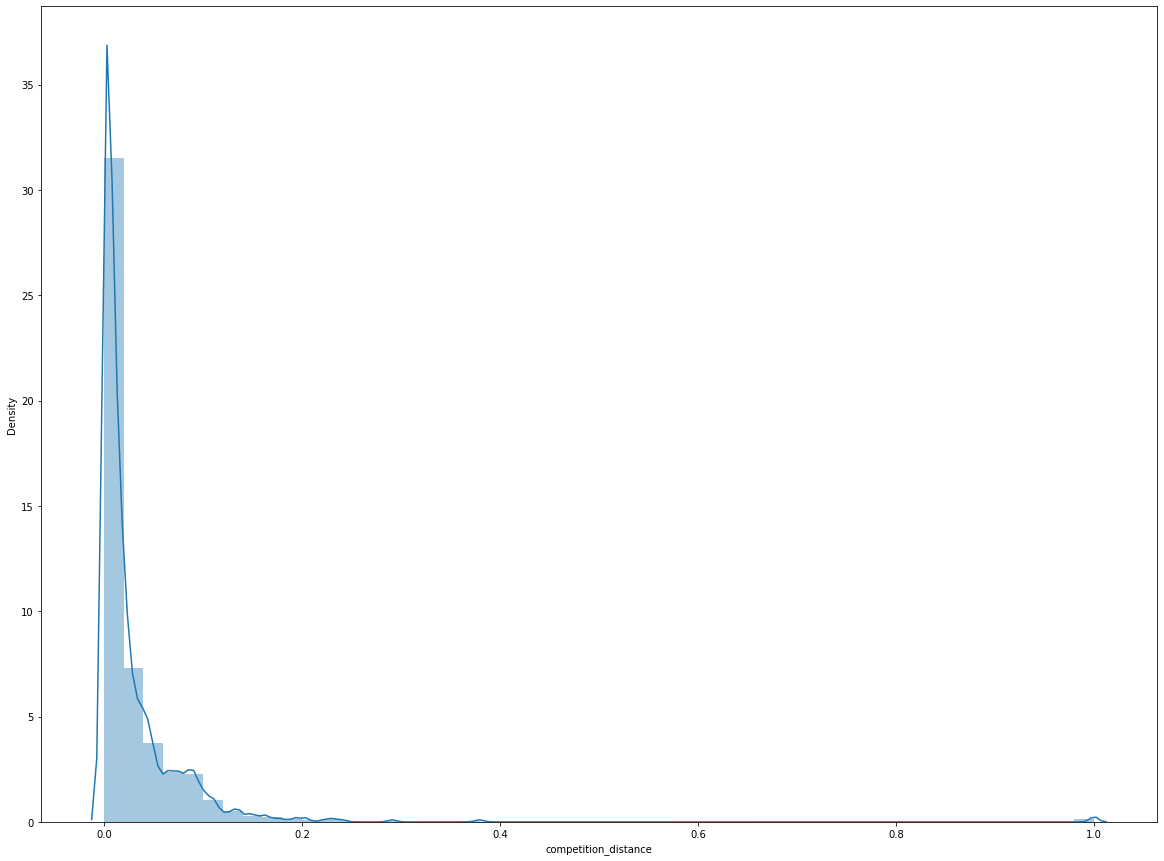

In [61]:
plt.figure(figsize=(20,15))
sns.distplot(df5['competition_distance']);

## 5.3 Transformação

### 5.3.1 Encoding

In [62]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,0.006251,...,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,0.002750,...,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,0.070557,...,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,0.003000,...,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,0.149465,...,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0


In [223]:
# variaveis categoricas

# state_holiday (one hot encoding)

df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type (label encoding)

le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump( le, open('parameter/store_type_scaler.pkl', 'wb'))

# assortment (ordinal encoding)

assortment_dict = {'basic': 1,
                  'extra': 2,
                  'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)


### 5.3.2 Response Variable Transformation

In [64]:
df5['sales'] = np.log1p(df5['sales'])

/opt/anaconda3/envs/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

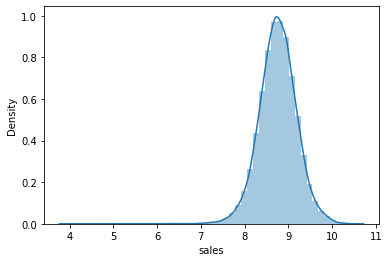

In [65]:
sns.distplot(df5['sales'])

### 5.3.3 Nature Transformation

In [66]:
# variaveis de natureza ciclica

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))



In [67]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,0.006251,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,0.002750,11,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,0.070557,12,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,0.003000,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,0.149465,4,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# 6.0 PASSO 06 - SELEÇÃO DE VARIÁVEIS

In [68]:
df6 = df5.copy()

## 6.1 Split Dataframe into training and test dataset

In [69]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,0.006251,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,0.002750,11,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,0.070557,12,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,0.003000,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,0.149465,4,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


In [70]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'year_week', 'competition_since']
df6 = df6.drop(cols_drop, axis=1)


In [71]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)


Timestamp('2015-06-19 00:00:00')

In [72]:
# training dataset

X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']


# test dataset
 
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']


print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selection

In [73]:
#  training and test dataset for Boruta

X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

In [74]:
# define random forest regressor
rf = RandomForestRegressor(n_jobs=-1)

In [75]:
# # define boruta

# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)


### 6.2.1 Best Features from Boruta

In [76]:
cols_selected = boruta.support_.tolist()

# best features

X_train_fs = X_train.drop(['date','sales'], axis=1)

cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#not selected boruta

cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))


NameError: name 'boruta' is not defined

In [81]:
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'month_cos',
     'month_sin',
     'day_sin',
     'day_cos',
     'week_of_year_cos',
     'week_of_year_sin',
     'day_of_week_sin',
     'day_of_week_cos']


# columns to add

feat_to_add = ['date', 'sales']

# final features

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [82]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin',
 'day_of_week_sin',
 'day_of_week_cos']

# 7.0 PASSO 07 - MACHINE LEARNING MODELLING

In [142]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation

x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [84]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})

aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [85]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [146]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [86]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression Regularized Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized Lasso,1889.002495,0.294493,2724.258707


### 7.3.1 Linear Regression Regularized Model - Lasso - Cross Validation

In [147]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2117.0 +/- 342.66,0.29 +/- 0.01,3055.74 +/- 507.37


## 7.4 Random Forest Regressor

In [87]:

# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.824817,0.099693,1008.174054


### 7.4.1 Random Forest Regressor - Cross Validation

In [148]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.46 +/- 217.81,0.12 +/- 0.02,1256.16 +/- 317.88


## 7.5 XGBoost Regressor

In [161]:

# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=100,
                            eta=0.01,
                            max_depth=10,
                            subsample=0.7,
                            colsample_bytree=0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.685737,0.949484,7330.936513


## 7.5.1 XGBoost Regressor - Cross Validation

In [151]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
xgb_result_cv                        
                

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.14 +/- 588.56,0.95 +/- 0.0,7715.15 +/- 689.41


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [89]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.824817,0.099693,1008.174054
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression Regularized Lasso,1889.002495,0.294493,2724.258707
0,XGBoost Regressor,6683.602213,0.949501,7330.746126


### 7.6.2 Real Performance - Cross Validation

In [153]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2117.0 +/- 342.66,0.29 +/- 0.01,3055.74 +/- 507.37
0,Random Forest Regressor,837.46 +/- 217.81,0.12 +/- 0.02,1256.16 +/- 317.88
0,XGBoost Regressor,7049.14 +/- 588.56,0.95 +/- 0.0,7715.15 +/- 689.41


# 8.0 PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [168]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
        }

MAX_EVAL = 5

In [ ]:
warnings.filterwarnings('ignore')

final_result = pd.DataFrame()

for i in range (MAX_EVAL):
    #choose values for parameters randomly
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print( hp )
    
    # model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                n_estimators=hp['n_estimators'],
                                eta=hp['eta'],
                                max_depth=hp['max_depth'],
                                subsample=hp['subsample'],
                                colsample_bytree=hp['colsample_bytree'],
                                min_child_weight=hp['min_child_weight'])

    # performance
    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
    final_result = pd.concat([final_result, result])

final_result


{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3


## 8.2 Final Model

In [170]:
param_tuned = {
    'n_estimators':3000 ,
    'eta':0.03 ,
    'max_depth':5 ,
    'subsample':0.7 ,
    'colsample_bytree':0.7 ,
    'min_child_weight':3 
        }

In [171]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'],
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight']).fit (x_train, y_train)

# prediction

yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance

xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,763.52982,0.115072,1096.841136


In [182]:
mpe = mean_percentage_error (np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe


-0.018778136856635805

In [179]:
pickle.dump( model_xgb_tuned, open('model/model_rossman.pkl', 'wb'))



# 9.0 PASSO 09 - TRADUCAO E INTERPRETACAO DO ERRO

In [185]:
df9 = X_test [cols_selected_boruta_full]

# rescale

df9['sales']  = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [195]:
# Sum of predictions

df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()


# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2= df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# merge

df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge( df91, df9_aux3, how='inner', on='store')

# Scenarios

df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns

df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]



In [197]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,108560.968750,105146.699039,111975.238461,3414.269711,0.609552
908,909,219877.062500,211970.095172,227784.029828,7906.967328,0.517785
169,170,207912.531250,206400.084334,209424.978166,1512.446916,0.374461
901,902,198409.046875,197044.153888,199773.939862,1364.892987,0.340563
875,876,198069.015625,194045.655645,202092.375605,4023.359980,0.320645


<AxesSubplot:xlabel='store', ylabel='MAPE'>

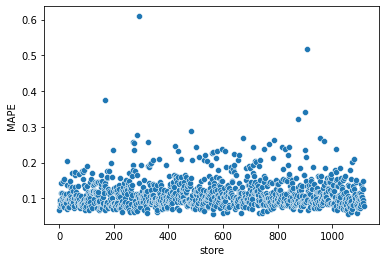

In [198]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2 Total Performance

In [205]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'Index': 'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,index,Values
0,predictions,"R$286,618,560.00"
1,worst_scenario,"R$285,763,897.17"
2,best_scenario,"R$287,473,233.30"


## 9.3 Machine Learning Performance

In [214]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']


<AxesSubplot:xlabel='predictions', ylabel='error'>

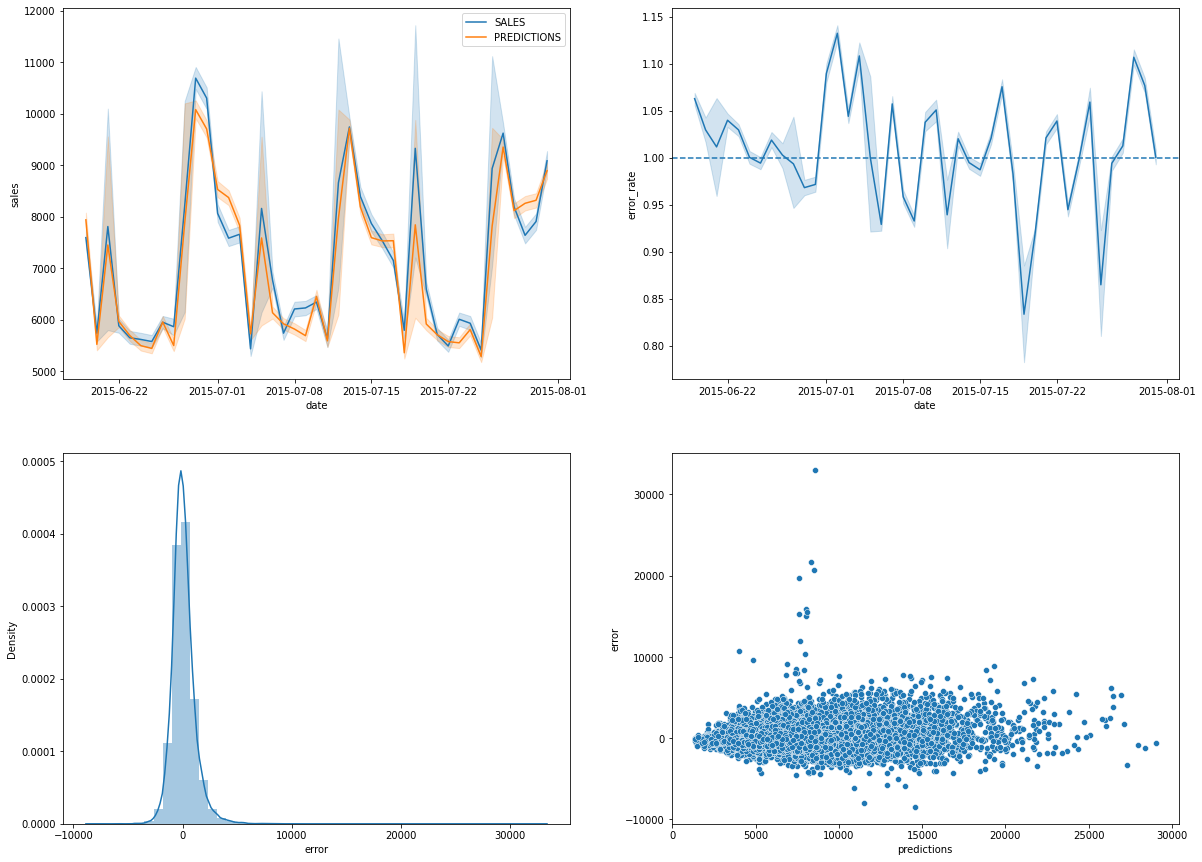

In [215]:
plt.figure(figsize=(20, 15))

plt.subplot (2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9,  label='PREDICTIONS')

plt.subplot (2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot (2,2,3)
sns.distplot(df9['error'])

plt.subplot (2,2,4)
sns.scatterplot(df9['predictions'], df9['error'])


# 10.0 PASS 10 - DEPLOY MODEL TO PRODUCTION

## 10.1 Rossman Class

In [243]:
import pickle 
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path='/Users/joaodequeiroz/Documents/Data_Science/repos/Store-Sales-Prediction/'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
    
    
    def data_cleaning (self, df1):     
        

        ## 1.1 Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
               'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
               'CompetitionDistance', 'CompetitionOpenSinceMonth',
               'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
               'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore (x) 
        cols_new = list(map (snakecase, cols_old))

        #rename
        df1.columns = cols_new


        ## 1.3 Data Types

        df1['date'] = pd.to_datetime(df1['date'])


        ## 1.5 Fillout NA

        df1['competition_distance'].max()

        # competition_distance              2642

        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan( x ) else x)

        # competition_open_since_month    323348
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        # competition_open_since_year     323348
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        # promo2_since_week               508031
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year               508031
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval                  508031
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dez'}
        df1['promo_interval'].fillna(0, inplace=True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        ## 1.6 Change Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

        return df1
    
    def feature_engineering (self, df2):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime (x + '-1', '%Y-%W-%w') - datetime.timedelta (days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


        # 3.0 PASSO 03 - FILTRAGEM DAS VARIÁVEIS

        ## 3.1 Filtragem das linhas

        df2 = df2[df2['open'] != 0]

        ## 3.2 Seleção das colunas

        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)

        return df2

    def data_preparation (self, df5):
        
        # 5.2 rescaling 
        # competitiion distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values )

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values )
        
        # promo time week (Min-Max Scaler)
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values )
        

        ## 5.3 Transformação

        ### 5.3.1 Encoding
        # variaveis categoricas
        # state_holiday (one hot encoding)

        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type (label encoding)

        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])


        # assortment (ordinal encoding)
        assortment_dict = {'basic': 1,
                          'extra': 2,
                          'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)


        ### 5.3.3 Nature Transformation

        # variaveis de natureza ciclica

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

        
        cols_selected = [
             'store',
             'promo',
             'store_type',
             'assortment',
             'competition_distance',
             'competition_open_since_month',
             'competition_open_since_year',
             'promo2',
             'promo2_since_week',
             'promo2_since_year',
             'competition_time_month',
             'promo_time_week',
             'month_cos',
             'month_sin',
             'day_sin',
             'day_cos',
             'week_of_year_cos',
             'week_of_year_sin',
             'day_of_week_sin',
             'day_of_week_cos']


        return df5[cols_selected]
    
    def get_prediction (self, model, original_data, test_data):
        #prediction
        pred = model.predict(test_data)
        
        #join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')
    
    

## 10.2 API Handler

In [264]:
import pandas as pd
import pickle
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann


# loading model

model = pickle.load(open('/Users/joaodequeiroz/Documents/Data_Science/repos/Store-Sales-Prediction/model/model_rossman.pkl', 'rb'))

# initialize api

app = Flask( __name__ )

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
        if isinstance (test_json, dict): #unique example
            test_raw = pd.DataFrame (test_json, index=[0])
        
        else:  #multiple examples
            test_raw = pd.DataFrame (test_json, columns=test_json[0].keys())
    
        # instanciar rossman class

        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # feature engineering
        df2 = pipeline.feature_engineering(df1)

        # data preparation
        df3 = pipeline.data_preparation(df2)

        # predict
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response
    
    else:
        return Response('{}', status=200, mimetype='application/json')


if __name__ == '__main__':
    app.run('0.0.0.0')
    

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [296]:
df10 = pd.read_csv('/Users/joaodequeiroz/Documents/Data_Science/repos/Store-Sales-Prediction/data/test.csv')


In [297]:
# merge test dataset + store

df_test = pd.merge( df10, df_store_raw, how='left', on='Store')

# choose store for prediction 
df_test = df_test[df_test['Store'].isin([12,23,35])]

# remove data that days are closed

df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)



In [298]:
# convert dataframe to json

data = json.dumps(df_test.to_dict(orient='records'))


In [299]:
# API call

#url = 'http://192.168.1.5:5000/rossmann/predict'
url = 'https://rossmann-model-prediction-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))


Status Code 200


In [300]:
d1 = pd.DataFrame (r.json(), columns=r.json()[0].keys())

In [301]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,12,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,1070.0,...,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,6963.408691
1,23,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,d,basic,4060.0,...,2015,9,17,38,2015-37,2005-08-01T00:00:00.000Z,123,2015-09-14T00:00:00.000Z,0,5977.031250
2,35,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,d,extended,7660.0,...,2015,9,17,38,2015-37,2000-10-01T00:00:00.000Z,182,2011-12-26T00:00:00.000Z,194,11144.768555
3,12,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,extended,1070.0,...,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,6946.903320
4,23,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,d,basic,4060.0,...,2015,9,16,38,2015-37,2005-08-01T00:00:00.000Z,123,2015-09-14T00:00:00.000Z,0,6009.214844


In [302]:
# soma de quanto vai vender nas 6 semsnas

d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range (len(d2)):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
            d2.loc[i, 'store'],
            d2.loc[i, 'prediction']))

Store Number 12 will sell R$268,725.79 in the next 6 weeks
Store Number 23 will sell R$241,298.56 in the next 6 weeks
Store Number 35 will sell R$472,233.01 in the next 6 weeks


In [303]:
d2

,store,prediction
0,12,268725.787109
1,23,241298.561523
2,35,472233.013672
